<a href="https://colab.research.google.com/github/DariaDon/LR_ML/blob/main/%D0%A1%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_UrFU_AI_Eng_2022_Reg_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urfuaieng2022reg2/studentRegistration.csv
/kaggle/input/urfuaieng2022reg2/studentAssessment.csv
/kaggle/input/urfuaieng2022reg2/studentInfo.csv
/kaggle/input/urfuaieng2022reg2/studentVle.csv
/kaggle/input/urfuaieng2022reg2/vle.csv
/kaggle/input/urfuaieng2022reg2/Test_Who.csv
/kaggle/input/urfuaieng2022reg2/Submission_reg.csv
/kaggle/input/urfuaieng2022reg2/Train_Who.csv
/kaggle/input/urfuaieng2022reg2/assessments.csv
/kaggle/input/urfuaieng2022reg2/courses.csv
/kaggle/input/urfuaieng2022reg2/Train_Target_reg.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Загружаем Данные

Сразу удаляем дубликаты

In [ ]:
# данные которые "все"
ass = pd.read_csv('/kaggle/input/urfuaieng2022reg2/assessments.csv')
ass.drop_duplicates(keep='first', inplace=True)
ass.reset_index(drop=True, inplace=True)

courses = pd.read_csv('/kaggle/input/urfuaieng2022reg2/courses.csv')
courses.drop_duplicates(keep='first', inplace=True)
courses.reset_index(drop=True, inplace=True)

results = pd.read_csv('/kaggle/input/urfuaieng2022reg2/studentAssessment.csv')
results.drop_duplicates(keep='first', inplace=True)
results.reset_index(drop=True, inplace=True)

info = pd.read_csv('/kaggle/input/urfuaieng2022reg2/studentInfo.csv')
info.drop_duplicates(keep='first', inplace=True)
info.reset_index(drop=True, inplace=True)

reg = pd.read_csv('/kaggle/input/urfuaieng2022reg2/studentRegistration.csv')
reg.drop_duplicates(keep='first', inplace=True)
reg.reset_index(drop=True, inplace=True)

vle = pd.read_csv('/kaggle/input/urfuaieng2022reg2/studentVle.csv')
vle.drop_duplicates(keep='first', inplace=True)
vle.reset_index(drop=True, inplace=True)

materials = pd.read_csv('/kaggle/input/urfuaieng2022reg2/vle.csv')
materials.drop_duplicates(keep='first', inplace=True)
materials.reset_index(drop=True, inplace=True)

## Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [ ]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
ass['id_assessment'] = ass['id_assessment'].astype(object)

In [ ]:
ass.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


## Assessments results (результаты оценки)

1. **id_assessment** – идентификационный номер оценки.
2. **id_student** –уникальный идентификационный номер студента.
3. **date_submitted** – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
4. **is_banked** – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации.

In [ ]:
results.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [ ]:
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)

In [ ]:
results.head()  # Метод .head() - первые 5 строк

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0


## Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [ ]:
courses.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [ ]:
courses.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


## Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [ ]:
reg.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
reg['id_student'] = reg['id_student'].astype(object)

In [ ]:
reg.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


## VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [ ]:
materials.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
materials['id_site'] = materials['id_site'].astype(object)

In [ ]:
materials.head() # Метод .head() - первые 5 строк

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


## VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

In [ ]:
vle.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868110 entries, 0 to 9868109
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 451.7+ MB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)

In [ ]:
vle.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546614,-10,11
3,AAA,2013J,28400,546714,-10,1
4,AAA,2013J,28400,546652,-10,8


## Student information

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [ ]:
info.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
info['id_student'] = info['id_student'].astype(object)

In [ ]:
info.head()  # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


## Регистрация + Информация о курсах

In [ ]:
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')
regCourses.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length
0,AAA,2013J,11391,-159.0,268
1,AAA,2013J,28400,-53.0,268
2,AAA,2013J,30268,-92.0,268
3,AAA,2013J,31604,-52.0,268
4,AAA,2013J,32885,-176.0,268


## Регистрация + Информация о курсах + Инфа о студентах

In [ ]:
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')
regCoursesInfo

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,269,F,Wales,Lower Than A Level,10-20,0-35,0,30,N
32589,GGG,2014J,2645731,-23.0,269,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N
32590,GGG,2014J,2648187,-129.0,269,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N


## VLE + studentVLE

In [ ]:
VLEmaterials = pd.merge(vle, materials, on=['code_module', 'code_presentation', 'id_site'], how='inner')
VLEmaterials

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,8,forumng,NaN,NaN
3,AAA,2013J,30268,546652,-10,3,forumng,NaN,NaN
4,AAA,2013J,30268,546652,-10,2,forumng,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9868105,GGG,2014J,647054,896969,227,8,oucontent,NaN,NaN
9868106,GGG,2014J,499187,896969,228,8,oucontent,NaN,NaN
9868107,GGG,2014J,629258,896969,228,23,oucontent,NaN,NaN
9868108,GGG,2014J,534672,896969,228,1,oucontent,NaN,NaN


Чтобы добавить учесть признаки из этой таблицы, надо агрегировать данные. Добавим признаки:

* общее количество взаимодействий с материалом для каждого студента
* среднее количество дней с начала модуля до взаимодействия
* количество дней, когда было взаимодействие с модулем
* среднее значение week_from

In [ ]:
ass_features = VLEmaterials.groupby(['code_module', 'code_presentation', 'id_student']) \
                           .agg(sum_click=('sum_click', 'sum'),
                                date_mean=('date', 'mean'),
                                date_count=('date', 'count'),
                                week_mean=('week_from', 'mean')).reset_index()

In [ ]:
ass_features.head()

,code_module,code_presentation,id_student,sum_click,date_mean,date_count,week_mean
0,AAA,2013J,11391,922,101.651042,192,1.454545
1,AAA,2013J,28400,1409,86.881643,414,1.583333
2,AAA,2013J,30268,260,2.263889,72,1.250000
3,AAA,2013J,31604,2007,105.263591,607,1.705882
4,AAA,2013J,32885,1012,91.337313,335,1.423077


Значений меньше на 3000, так что далее, присоединяя эту таблицу, не используем inner join

# Теперь все вместе

In [ ]:
all_feature = pd.merge(regCoursesInfo, ass_features, on=['code_module', 'code_presentation', 'id_student'], how='left')
all_feature

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,sum_click,date_mean,date_count,week_mean
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,922.0,101.651042,192.0,1.454545
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1409.0,86.881643,414.0,1.583333
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,260.0,2.263889,72.0,1.250000
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2007.0,105.263591,607.0,1.705882
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1012.0,91.337313,335.0,1.423077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,269,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,38.0,14.058824,17.0,2.000000
32589,GGG,2014J,2645731,-23.0,269,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,855.0,145.897674,215.0,2.000000
32590,GGG,2014J,2648187,-129.0,269,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,291.0,123.734043,94.0,3.000000
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,273.0,36.271186,59.0,1.571429


# И наконец воспользуемся таблицами с результатами и информацией по оценкам

In [ ]:
assResults = pd.merge(ass, results, on=['id_assessment'], how='inner')
assResults

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0
...,...,...,...,...,...,...,...,...,...
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0


Чтобы добавить учесть признаки из этой таблицы, надо агрегировать данные. Добавим признаки:

* Сумма весов оценок
* Cредний вес оценки
* Среднее кол-во дней с начала модуля
* Среднее количество дней от начала модуля до его окончательной сдачи (date)
* Среднее кол-во дней с начала модуля, до предоставления результата студентом
* Кол-во дней с начала модуля

In [ ]:
assResults['diff'] = assResults['date'] - assResults['date_submitted']

ass_features = assResults.groupby(['code_module', 'code_presentation', 'id_student']) \
                         .agg(weight_sum=('weight', 'sum'),
                              weight_mean=('weight', 'mean'),
                              date_res_mean=('date', 'mean'),
                              diff_mean=('diff', 'mean'),
                              date_submitted_res_mean=('date_submitted', 'mean'),
                              date_submitted_res_count=('date_submitted', 'count')).reset_index()

In [ ]:
ass_features.head()

,code_module,code_presentation,id_student,weight_sum,weight_mean,date_res_mean,diff_mean,date_submitted_res_mean,date_submitted_res_count
0,AAA,2013J,11391,100.0,20.0,114.2,1.8,112.4,5
1,AAA,2013J,28400,100.0,20.0,114.2,0.0,114.2,5
2,AAA,2013J,31604,100.0,20.0,114.2,2.0,112.2,5
3,AAA,2013J,32885,100.0,20.0,114.2,-11.4,125.6,5
4,AAA,2013J,38053,100.0,20.0,114.2,-2.0,116.2,5


In [ ]:
all_feature = pd.merge(all_feature, ass_features, on=['code_module', 'code_presentation', 'id_student'], how='left')
all_feature

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,...,sum_click,date_mean,date_count,week_mean,weight_sum,weight_mean,date_res_mean,diff_mean,date_submitted_res_mean,date_submitted_res_count
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,...,922.0,101.651042,192.0,1.454545,100.0,20.0,114.200000,1.800000,112.400000,5.0
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,...,1409.0,86.881643,414.0,1.583333,100.0,20.0,114.200000,0.000000,114.200000,5.0
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,...,260.0,2.263889,72.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,...,2007.0,105.263591,607.0,1.705882,100.0,20.0,114.200000,2.000000,112.200000,5.0
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,...,1012.0,91.337313,335.0,1.423077,100.0,20.0,114.200000,-11.400000,125.600000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,269,F,Wales,Lower Than A Level,10-20,0-35,...,38.0,14.058824,17.0,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
32589,GGG,2014J,2645731,-23.0,269,F,East Anglian Region,Lower Than A Level,40-50%,35-55,...,855.0,145.897674,215.0,2.000000,0.0,0.0,192.444444,36.222222,156.222222,9.0
32590,GGG,2014J,2648187,-129.0,269,F,South Region,A Level or Equivalent,20-30%,0-35,...,291.0,123.734043,94.0,3.000000,0.0,0.0,192.444444,45.333333,147.111111,9.0
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,...,273.0,36.271186,59.0,1.571429,0.0,0.0,145.000000,79.500000,65.500000,2.0


# Выделение тренировочной и тестовой выборки

Список студентов, соответсвующих модулей и презентаций (разные студенты могут сдавать разные модули)

In [ ]:
Train_Who = pd.read_csv('/kaggle/input/urfuaieng2022reg2/Train_Who.csv')
Test_Who = pd.read_csv('/kaggle/input/urfuaieng2022reg2/Test_Who.csv')

Left Join по всему содержимому `Train_Who`, чтобы ничего не упустить

In [ ]:
Train = pd.merge(Train_Who, all_feature, on=['id_student', 'code_module', 'code_presentation'], how='left')
Train.index = Train.ID
Train.drop(columns = ['ID', 'id_student'], inplace = True)
Train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,sum_click,date_mean,date_count,week_mean,weight_sum,weight_mean,date_res_mean,diff_mean,date_submitted_res_mean,date_submitted_res_count
ID,,,,,,,,,,,,,,,,,,,,,
0,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,1614.0,109.793594,562.0,NaN,200.0,28.571429,123.857143,0.571429,123.285714,7.0
1,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,686.0,29.532710,321.0,NaN,40.0,13.333333,55.333333,0.000000,55.333333,3.0
2,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,...,1862.0,105.656814,609.0,2.111111,191.0,23.875000,131.000000,-7.571429,151.750000,8.0
3,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,...,2035.0,67.452012,646.0,8.092784,75.0,6.818182,181.181818,74.000000,107.181818,11.0
4,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,...,183.0,-5.000000,80.0,5.000000,12.5,12.500000,19.000000,0.000000,19.000000,1.0


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26074 non-null  object 
 1   code_presentation           26074 non-null  object 
 2   date_registration           26037 non-null  float64
 3   module_presentation_length  26074 non-null  int64  
 4   gender                      26074 non-null  object 
 5   region                      26074 non-null  object 
 6   highest_education           26074 non-null  object 
 7   imd_band                    25187 non-null  object 
 8   age_band                    26074 non-null  object 
 9   num_of_prev_attempts        26074 non-null  int64  
 10  studied_credits             26074 non-null  int64  
 11  disability                  26074 non-null  object 
 12  sum_click                   23364 non-null  float64
 13  date_mean                   233

аналогично для тестовой выборки

In [ ]:
Test = pd.merge(Test_Who, all_feature, on=['id_student', 'code_module', 'code_presentation'], how='left')
Test.index = Test.ID
Test.drop(columns = ['ID', 'id_student'], inplace = True)
Test

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,sum_click,date_mean,date_count,week_mean,weight_sum,weight_mean,date_res_mean,diff_mean,date_submitted_res_mean,date_submitted_res_count
ID,,,,,,,,,,,,,,,,,,,,,
26074,DDD,2014J,-92.0,262,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,295.0,139.804348,46.0,NaN,200.0,28.571429,95.833333,20.333333,99.285714,7.0
26075,CCC,2014B,-109.0,241,M,North Western Region,HE Qualification,0-10%,35-55,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26076,BBB,2013B,-88.0,240,F,North Western Region,Lower Than A Level,50-60%,35-55,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26077,CCC,2014J,-34.0,269,M,South Region,A Level or Equivalent,20-30%,0-35,0,...,260.0,8.805195,77.0,1.125000,2.0,2.000000,18.000000,-3.000000,21.000000,1.0
26078,BBB,2013J,-134.0,268,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,DDD,2013J,-54.0,261,M,South Region,Lower Than A Level,10-20,0-35,0,...,166.0,35.413043,46.0,NaN,22.5,11.250000,39.000000,-2.500000,41.500000,2.0
32589,DDD,2013B,-34.0,240,F,Yorkshire Region,A Level or Equivalent,30-40%,0-35,1,...,168.0,46.000000,81.0,NaN,16.0,5.333333,61.000000,-1.666667,62.666667,3.0
32590,AAA,2013J,-22.0,268,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,...,2139.0,115.882704,503.0,1.350000,100.0,20.000000,114.200000,0.000000,114.200000,5.0


In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 6519 non-null   object 
 1   code_presentation           6519 non-null   object 
 2   date_registration           6511 non-null   float64
 3   module_presentation_length  6519 non-null   int64  
 4   gender                      6519 non-null   object 
 5   region                      6519 non-null   object 
 6   highest_education           6519 non-null   object 
 7   imd_band                    6295 non-null   object 
 8   age_band                    6519 non-null   object 
 9   num_of_prev_attempts        6519 non-null   int64  
 10  studied_credits             6519 non-null   int64  
 11  disability                  6519 non-null   object 
 12  sum_click                   5864 non-null   float64
 13  date_mean                   

# Визуализация

Соберем в список название столбцов с числовыми признаки

In [ ]:
num_cols = []
for col in Train.columns:
    if (Train[col].dtypes != object):
        num_cols += [col]

Добавим столбец с классом

In [ ]:
Target = pd.read_csv('/kaggle/input/urfuaieng2022reg2/Train_Target_reg.csv', index_col = 'ID')
Train = Train.join(Target)
Train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,date_mean,date_count,week_mean,weight_sum,weight_mean,date_res_mean,diff_mean,date_submitted_res_mean,date_submitted_res_count,weighted_score
ID,,,,,,,,,,,,,,,,,,,,,
0,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,109.793594,562.0,NaN,200.0,28.571429,123.857143,0.571429,123.285714,7.0,64.9125
1,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,29.532710,321.0,NaN,40.0,13.333333,55.333333,0.000000,55.333333,3.0,14.8625
2,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,...,105.656814,609.0,2.111111,191.0,23.875000,131.000000,-7.571429,151.750000,8.0,61.4300
3,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,...,67.452012,646.0,8.092784,75.0,6.818182,181.181818,74.000000,107.181818,11.0,39.5000
4,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,...,-5.000000,80.0,5.000000,12.5,12.500000,19.000000,0.000000,19.000000,1.0,9.2500


In [ ]:
col_plot = num_cols + ['weighted_score']

Посмотрим на гистограммы распределения по признакам

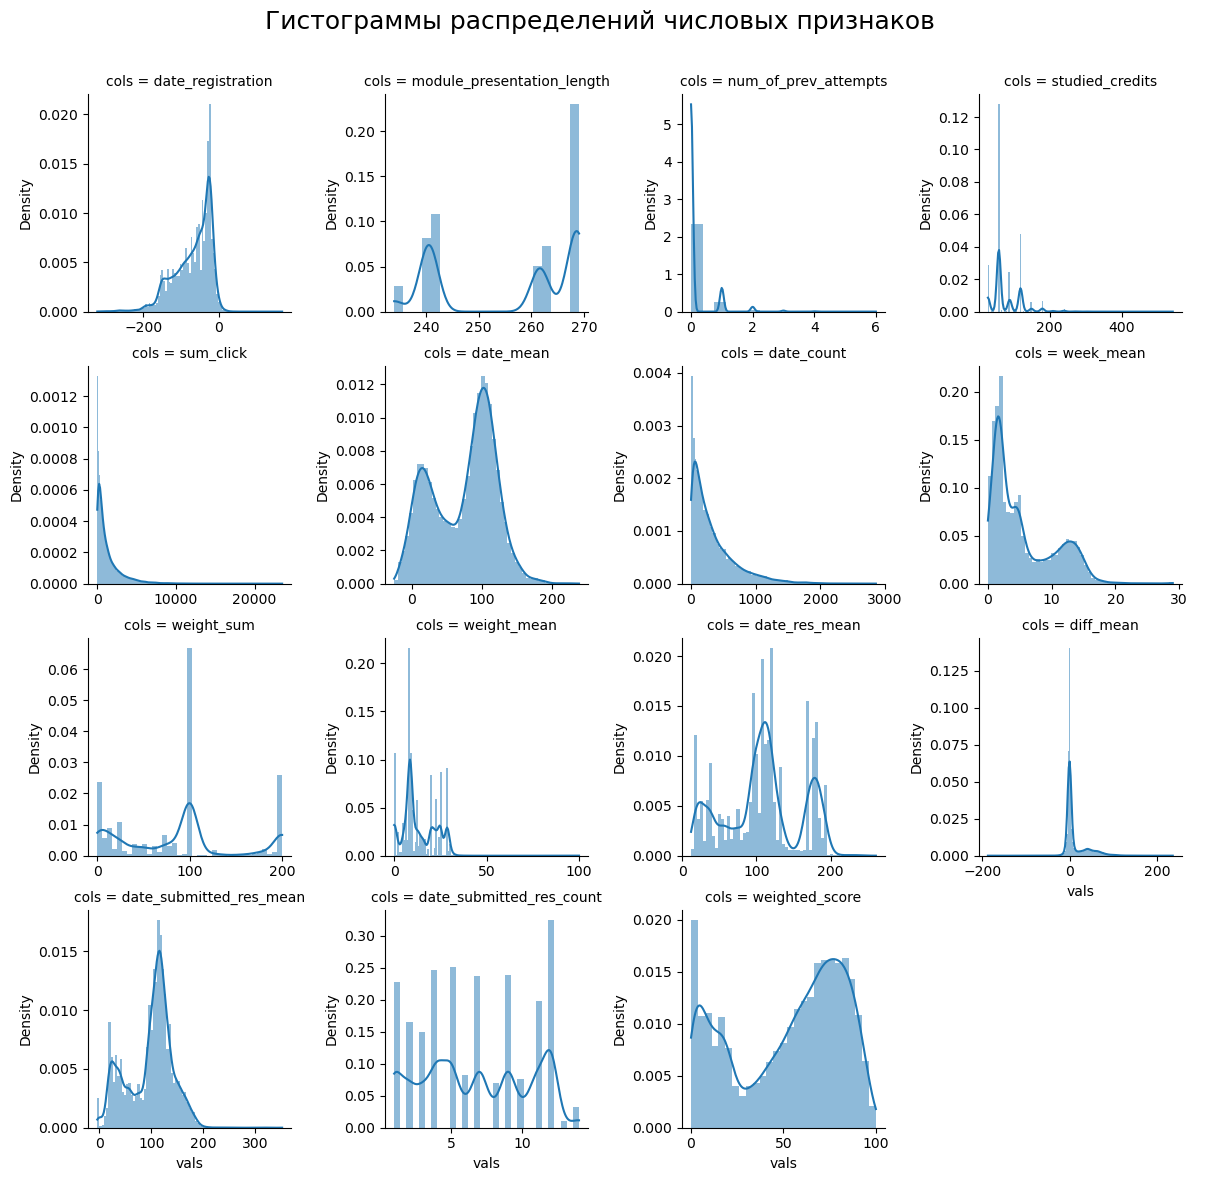

In [ ]:
f = Train[col_plot].melt(var_name='cols', value_name='vals')
g = sns.FacetGrid(f, col='cols', col_wrap=4, sharex=False, sharey=False, legend_out=True)
g = g.map(sns.histplot, 'vals', kde=True, stat='density', linewidth=0, bins='auto').add_legend()
plt.subplots_adjust(top=0.91)
g.fig.suptitle('Гистограммы распределений числовых признаков', fontsize=18);

На нормальное распределение не похоже конечно, но все таки попробуем посмотреть корреляцию Пирсона

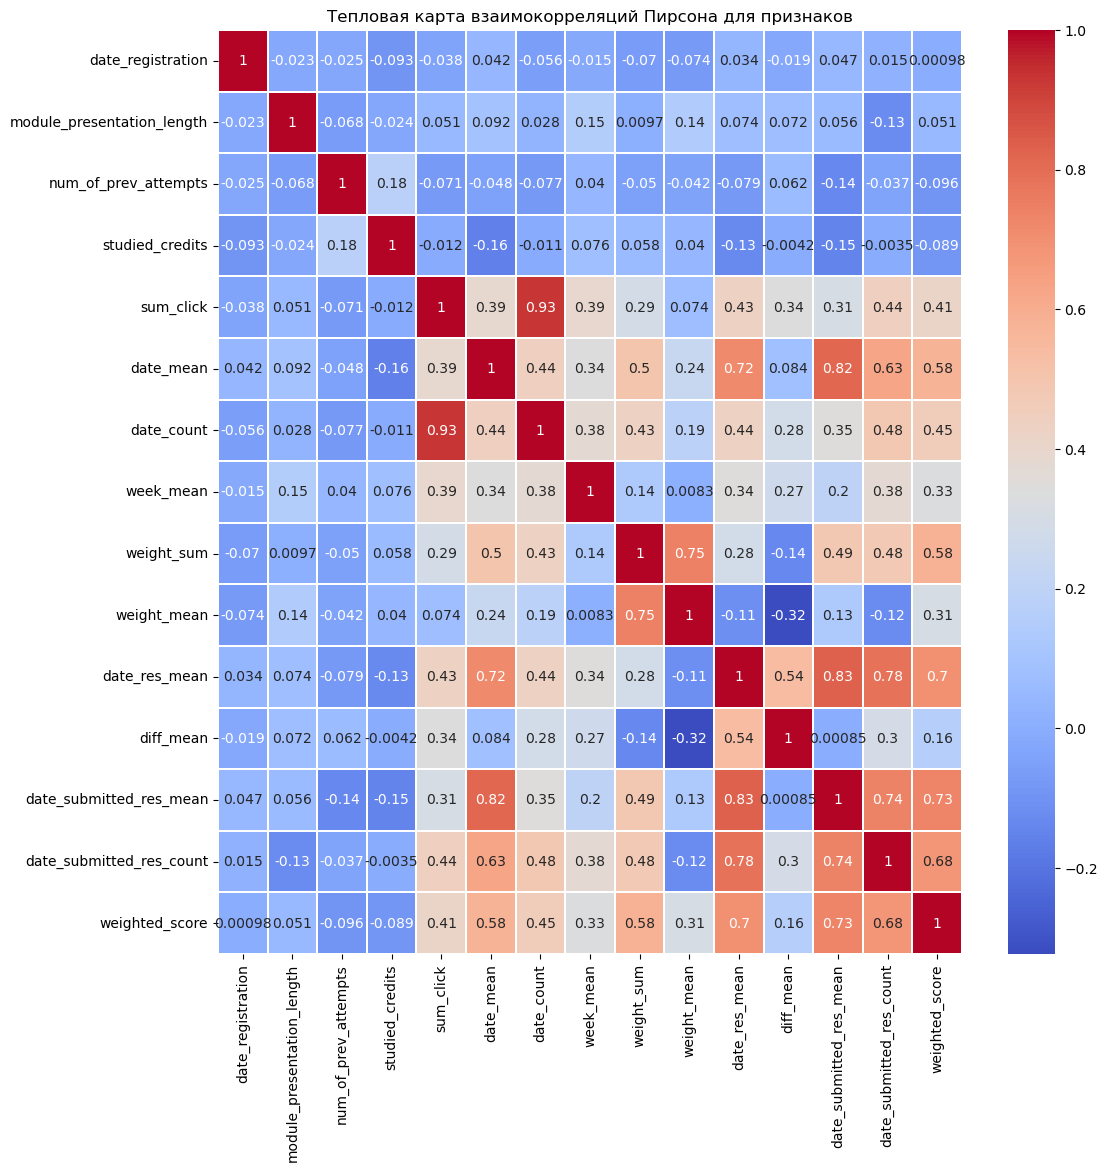

In [ ]:
plt.subplots(figsize=(12, 12))
sns.heatmap(Train[col_plot].corr(), linewidths=.01, cmap="coolwarm", annot=True)
plt.title("Тепловая карта взаимокорреляций Пирсона для признаков")
plt.show()

Т.к. признаки не имеют нормальные распределения, визуализируем коэффициент корреляции Спирмена для всех признаков

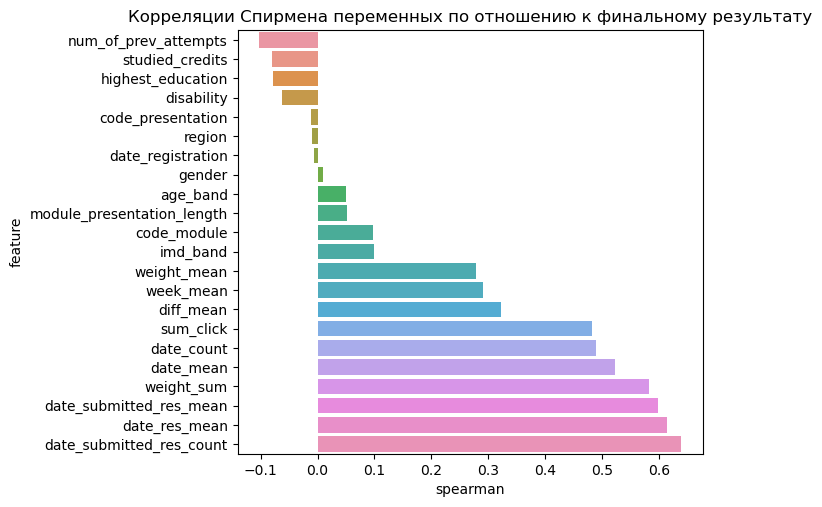

In [ ]:
spr = pd.DataFrame()
features = Train.columns.drop('weighted_score')
spr['feature'] = features
spr['spearman'] = [Train[f].corr(Train['weighted_score'], 'spearman') for f in features]
spr = spr.sort_values('spearman')
plt.figure(figsize=(6, 0.25*len(features)))
fig = sns.barplot(data=spr, y='feature', x='spearman', orient='h')
plt.title("Корреляции Спирмена переменных по отношению к финальному результату")
plt.show(fig)

На первый взгляд созданные признаки должны быть важны для обучения

# Обработка данных

В столбце imd_band много NaN, заменим самым частым значением

In [ ]:
Train.imd_band.mode()[0]

'20-30%'

In [ ]:
Train['imd_band'].loc[Train['imd_band'].isnull()] = Train['imd_band'].mode()[0]
Test['imd_band'].loc[Test['imd_band'].isnull()] = Train['imd_band'].mode()[0]

Теперь обработаем NaN в столбце date_registration, заполним медианным значением

In [ ]:
Train.date_registration.median()

-57.0

In [ ]:
Train['date_registration'].loc[Train['date_registration'].isnull()] = Train['date_registration'].median()
Test['date_registration'].loc[Test['date_registration'].isnull()] = Train['date_registration'].median()

In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 6519 non-null   object 
 1   code_presentation           6519 non-null   object 
 2   date_registration           6519 non-null   float64
 3   module_presentation_length  6519 non-null   int64  
 4   gender                      6519 non-null   object 
 5   region                      6519 non-null   object 
 6   highest_education           6519 non-null   object 
 7   imd_band                    6519 non-null   object 
 8   age_band                    6519 non-null   object 
 9   num_of_prev_attempts        6519 non-null   int64  
 10  studied_credits             6519 non-null   int64  
 11  disability                  6519 non-null   object 
 12  sum_click                   5864 non-null   float64
 13  date_mean                   

Теперь поработаем с числовыми признаками

In [ ]:
num_cols = []
for col in Train.columns:
    if (Train[col].dtypes != object):
        num_cols += [col]

num_cols.remove('weighted_score')

Выбросы удалять не стала, т.к. в итоге без них скор хуже

In [ ]:
#for col in num_cols:
#    z = np.abs(zscore(Train[[col]].loc[Train[col].notnull()]))
#    Train[[col]] = Train[[col]].loc[Train[col].notnull()][(z<3).all(axis=1)]

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26074 non-null  object 
 1   code_presentation           26074 non-null  object 
 2   date_registration           26074 non-null  float64
 3   module_presentation_length  26074 non-null  int64  
 4   gender                      26074 non-null  object 
 5   region                      26074 non-null  object 
 6   highest_education           26074 non-null  object 
 7   imd_band                    26074 non-null  object 
 8   age_band                    26074 non-null  object 
 9   num_of_prev_attempts        26074 non-null  int64  
 10  studied_credits             26074 non-null  int64  
 11  disability                  26074 non-null  object 
 12  sum_click                   23364 non-null  float64
 13  date_mean                   233

Удалим дубликаты и строки, где были выбросы

In [ ]:
Train.drop_duplicates(keep='first', inplace=True)
Train.reset_index(drop=True, inplace=True)

Заполняем пропуски 0

Да, слишком просто и неинтересно, но так скор лучше, чем если заменять медианой или модой

In [ ]:
col_NaN = ['sum_click', 'date_mean', 'date_count', 'week_mean', 'weight_sum', 'weight_mean', 'date_res_mean',
           'diff_mean', 'date_submitted_res_mean', 'date_submitted_res_count']

for col in col_NaN:
    Train[col] = Train[col].replace(np.nan).fillna(0)
    Test[col] = Test[col].replace(np.nan).fillna(0)

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26074 non-null  object 
 1   code_presentation           26074 non-null  object 
 2   date_registration           26074 non-null  float64
 3   module_presentation_length  26074 non-null  int64  
 4   gender                      26074 non-null  object 
 5   region                      26074 non-null  object 
 6   highest_education           26074 non-null  object 
 7   imd_band                    26074 non-null  object 
 8   age_band                    26074 non-null  object 
 9   num_of_prev_attempts        26074 non-null  int64  
 10  studied_credits             26074 non-null  int64  
 11  disability                  26074 non-null  object 
 12  sum_click                   26074 non-null  float64
 13  date_mean                   260

## Подготовим train, target и submission

In [ ]:
Target = Train.weighted_score
X_train = Train.drop(columns=['weighted_score', 'gender']).copy()

In [ ]:
Submission = pd.read_csv('/kaggle/input/urfuaieng2022reg2/Submission_reg.csv', index_col = 'ID')

In [ ]:
Submission.head()

,weighted_score
ID,
26074,52.319915
26075,52.319915
26076,52.319915
26077,52.319915
26078,52.319915


пригодилось то, что мы все id-шники закинули в тип данных `object`

теперь можем "автоматически" выполнять предварительную обработку по колонкам

In [ ]:
cat_columns = []
num_columns = []

for column_name in X_train.columns:
    if (X_train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))
print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['code_module', 'code_presentation', 'region', 'highest_education', 'imd_band', 'age_band', 'disability'] 
 len =  7
numerical columns:	  ['date_registration', 'module_presentation_length', 'num_of_prev_attempts', 'studied_credits', 'sum_click', 'date_mean', 'date_count', 'week_mean', 'weight_sum', 'weight_mean', 'date_res_mean', 'diff_mean', 'date_submitted_res_mean', 'date_submitted_res_count'] 
 len =  14


## Pipeline

Создаем объект `Pipeline`

Сначала создадим отдельно Pipeline для числовых данных (вставление пропусков + нормализация)

In [ ]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler()),
    ('scaler', MinMaxScaler())
])

Предобработка категориальных данных (вставление пропусков + One-Hot кодирование)

In [ ]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

На вход `ColumnTransformer` также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

"Обучаем" стандартно через `.fit()`

In [ ]:
X_train = preprocessors.fit_transform(X_train) # преобразуем  тренировочные данные
X_test = preprocessors.transform(Test) # преобразуем  тестовые данные

# Регрессия

In [ ]:
#model = LGBMRegressor()
#model.fit(X_train, Target)

In [ ]:
model = CatBoostRegressor()
model.fit(X_train, Target, verbose=False)

### Посмотрим важность признаков

Раз можно сабмитить только 5 раз в день, будем проверять через кросс-валидацию

In [ ]:
#cores = cross_val_score(model, X_train, Target, cv=7, scoring='neg_mean_squared_error').mean()
#cores

* предсказываем на тестовых данных через  `.predict()`

In [ ]:
predict = model.predict(X_test)

Складываем предсказание в фрейм загрузки

In [ ]:
Submission['weighted_score'] = predict

In [ ]:
Submission

,weighted_score
ID,
26074,57.061639
26075,62.981352
26076,64.863103
26077,0.939535
26078,1.788532
...,...
32588,5.803821
32589,5.051821
32590,74.943058


## Сохраняем предсказания

In [ ]:
Submission.to_csv('Submission9.csv',index=True)